<a id = 'top'></a>
## Maybe one day we'll find an asteroid that will bring life to Mars
(but for now, we'll just look at some simulated spectra)

Erika Hornecker and Mairead Heiger

- [imports](#imp)
- [data](#data)
- [generate synthetic spectrum](#sim)
    - [set it up](#set)
    - [profile](#voigt)
    - [plot it](#simplot)
- [specify the model](#stan)
    - [data for stan](#standat)
    - [build](#build)
    - [sample](#stansamp)
        - [estimates](#stanest)
- [plot the results](#results)
    - [best-fit](#fitplot)
    - [diagnostics](#diag)
        - [trace plots](#trace)
        - [autocorrelation](#tau)
        - [effective sample size](#ess)
        - [corner plot](#corner)
        - [energy](#energy)
    - [goodness of fit](#goodness)


<a id = 'imp'></a>
## Imports 

[Index](#top)

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table

import scipy.stats as stats

import arviz as az
import stan

import nest_asyncio

import asteroids_functions as fast

import pickle

In [2]:
nest_asyncio.apply()

<a id = 'data'></a>
## Data

[Index](#top)

In [3]:
linelist = ascii.read("CC_CI1_Features.csv")

In [4]:
linelist

<Table length=9>
                                   Feature                                    ...   mean 
                                    str76                                     ... float64
----------------------------------------------------------------------------- ... -------
                                                      (?) common in CI spect. ...   0.475
                                                 Fe3+ - Fe2+ charge transfers ...   0.725
              Fe2+ crystal field transitions in Fe2+- bearing phyllosilicates ...   0.925
                                                                    magnetite ...   1.005
               Fe2+ crystal field transitions in Fe2+-bearing phyllosilicates ...   1.125
                                                        Serpentines (from OH) ...    1.38
                                             Saponites (from OH, sharp bands) ...   1.405
                                            Saponites (from H2O, sharp bands) ...    1.46
Combination band dude to H-O-H bending plus O-H stretching\n(presence of H2O) ...    1.91

<a id = 'sim'></a>

# Generate synthetic spectrum

[Index](#top)

<a id = 'set'></a>

### Properties of the spectrum

[Index](#top)

In [5]:
M = 2.2                      # set the size of the wavelength grid
dM = 0.01                    # the step in the wavelength grid
x = np.arange(0,M,dM)        # this is the wavelength grid
k_t = 6                      # set the number of features
N = len(x)                   # the number of data points we have is related to the grid
ye = 0.01                    # error (noise)


<a id = 'Voigt'></a>

### Line profile

[Index](#top)

Gaussian broadening mechanisms contribute more to the shape of asteroid and meteorite reflectance spectra than Lorentzian mechanisms. Inhomogenous effects tend to produce Gaussian shapes and asteroid surfaces are replete with inhomogeneity, so we approximate its shape as purely Gaussian:

$G(x) = \phi \exp{-\frac{(x - \mu)^2}{(2\sigma^2)}}$


In [6]:
features, spectrum = fast.gen_spec(linelist['mean'], x, K = k_t, noise = ye)

<a id = 'simplot'></a>

### Plot the simulated spectrum

[Index](#top)

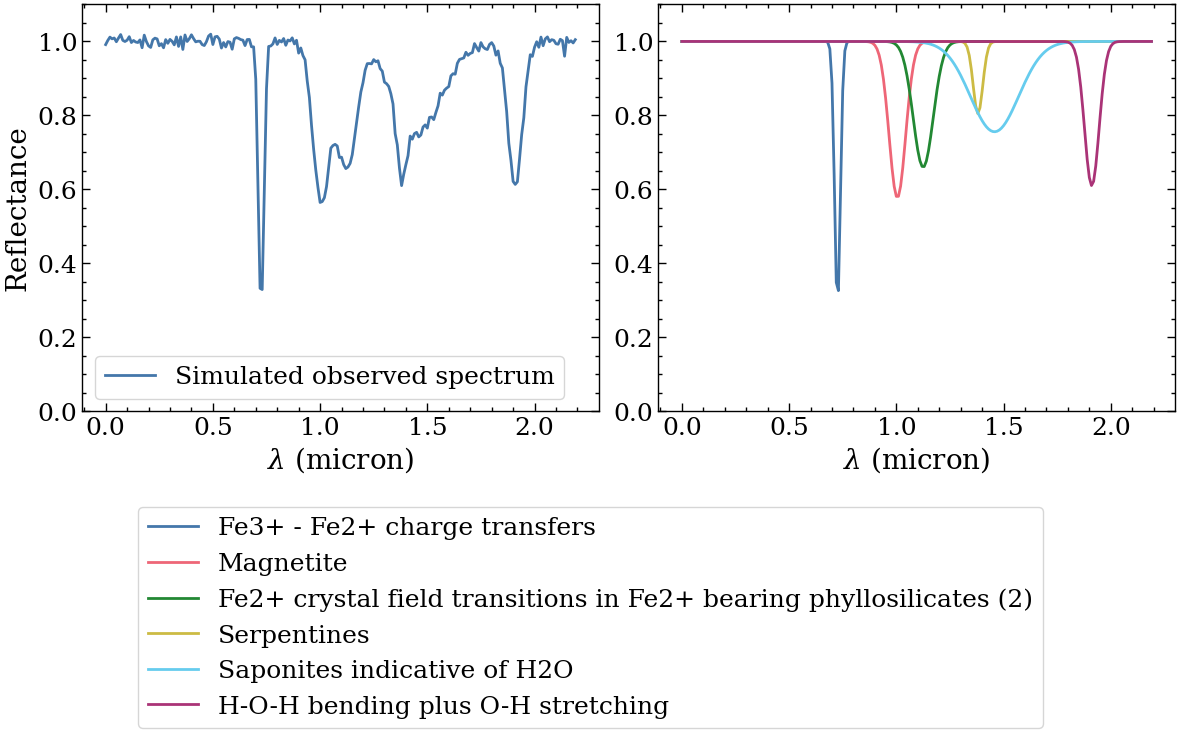

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# plot the observed spectrum
ax[0].plot(x, spectrum, '-', lw = 2)
ax[0].legend(["Simulated observed spectrum"])

# plot the components
for i in range(k_t):
    ax[1].plot(x, features['f'][i], lw = 2, label = linelist['label'][features['which']][i])

# format
fig.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.01))
ax[0].set_xlabel(r"$\lambda$ (micron)"); ax[1].set_xlabel(r"$\lambda$ (micron)")
ax[0].set_ylabel(r"Reflectance")
ax[0].set_ylim(0,1.1)
ax[1].set_ylim(0,1.1)

plt.tight_layout()

plt.show()

<a id = 'stan'></a>
## Specify the model

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)

[Index](#top)

In [8]:
# specify the model for stan
stan_code = """ 
functions {
    real G(data real x, real phi, real mu, real sigma){
        return -phi * exp(-(x - mu)^2./(2.*sigma^2.));
    }
}

data {
    int<lower=0> K;                     // number of features (mixture components)
    int<lower=0> N;                     // number of data points (depends on how finely you sample the spectrum)
    vector[N] yo;                       // observations (literally the values of the reflectance at lambda)
    real ye;                            // error on observation
    vector[N] x;                        // wavelength grid
    real del;                           // size of the little box around each mean
    vector[K] mut;                      // means of the known features (sorted)
    vector[K] mut_l;                    // range of the known features (left bound)
    vector[K] mut_r;                    // ^^ (right bound)
}   
   
parameters {   

    // characteristics of the features (the gaussians we want to recover)
    
    real<lower = mut_l[1] - 0.001, upper = mut_r[1] + 0.001>  common_feats;    // locations of the features 
    real<lower = mut_l[2] - 0.001, upper = mut_r[2] + 0.001>   fe32_charge;
    real<lower = mut_l[3] - 0.001, upper = mut_r[3] + 0.001> fe2_crystal_1;
    real<lower = mut_l[4] - 0.001, upper = mut_r[4] + 0.001>     magnetite;
    real<lower = mut_l[5] - 0.001, upper = mut_r[5] + 0.001> fe2_crystal_2;
    real<lower = mut_l[6] - 0.001, upper = mut_r[6] + 0.001>   serpentines;
    real<lower = mut_l[7] - 0.001, upper = mut_r[7] + 0.001>  oh_saponites;
    real<lower = mut_l[8] - 0.001, upper = mut_r[8] + 0.001> h2o_saponites;
    real<lower = mut_l[9] - 0.001, upper = mut_r[9] + 0.001>        hoh_oh;
    
    vector<lower = 0>[K] sigma;                     // width of the feature
                                
    vector<lower = -0.01, upper = 1.5>[K] phi;      // (negative) depth of the feature
                                        
    real epsilon;                                   // continuum level (offset of the entire spectrum from 0 -- like an intercept)
    
}

transformed parameters{
    // the "line" of our linear regression
    vector[K] mus = [common_feats, fe32_charge, fe2_crystal_1, magnetite, fe2_crystal_2, serpentines, oh_saponites, h2o_saponites, hoh_oh]';
    vector[K] ps;                                   // placeholder
    vector[N] yt;                                   // noiseless "true" value, yo = phi*yt + epsilon
    
    // if phi of feature k is non-zero, it's contributing to the observed reflectance, so it's worth constraining its mean, SD
    // otherwise, it doesn't, but the model will still do its best to constrain them
    // so instead we don't include them in the likelihod, and their mean, SD become dependent on the initial guess    
    
    for (n in 1:N){
        for (k in 1:K){
            if (phi[k] > 0.01){
                ps[k] = G(x[n], phi[k], mus[k], sigma[k]);       // the features that are doing things
            }                                                    
            else{
                ps[k] = 0;                                       // the features that don't actually exist                                                           
            }
        }
        yt[n] = sum(ps) + epsilon;
    }

}

model{

    // priors
    
    phi ~ normal(0.5,0.5);                          // height of peak
       
    common_feats   ~ normal(mut[1], del);  // each mean is unique and ordered
    fe32_charge    ~ normal(mut[2], del);
    fe2_crystal_1  ~ normal(mut[3], del);
    magnetite      ~ normal(mut[4], del);
    fe2_crystal_2  ~ normal(mut[5], del);
    serpentines    ~ normal(mut[6], del);
    oh_saponites   ~ normal(mut[7], del);
    h2o_saponites  ~ normal(mut[8], del);
    hoh_oh         ~ normal(mut[9], del);
    
    epsilon ~ normal(1, 1);                         // continuum level

    sigma ~ normal(0.1, 0.05);                      // sigma
    
    
    // likelihood
    
    yo ~ normal(yt, ye);
}
"""




<a id = 'standat'></a>

### Make a dictionary of the data for stan

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)


[Index](#top)

In [9]:
data = {}
data["K"] = 9                        # we have 9 features, although several of them should be 0 here
data["N"] = N                        # and N = M/dM samples on the curve
data["yo"] = spectrum                # and these are the values of the observed reflectance
data["ye"] = ye                      # with their error
data["x"] = x                        # at these values of lambda
data["del"] = 0.1                    # this is how big the little windowbox prior should be for each mu
data["mut"] = linelist['mean']       # and this is where we think they are
data["mut_l"] = linelist['left']     # ^^
data["mut_r"] = linelist['right']    # ^^


<a id = 'build'></a>

### Build the model

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)

[Index](#top)

In [10]:
fit = stan.build(program_code = stan_code, data = data) # build the model

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_j_fos5k1/model_2ci5vm66.stan', line 84, column 24: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_j_fos5k1/model_2ci5vm66.stan', line 54, column 12: A
    control flow statement depends on parameter(s): phi.
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,

<a id = 'stansamp'></a>

### Sample

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)

[Index](#top)

In [11]:
# initial guess (give it a really good one)
z = np.zeros(9)
z[features['which']] = features['phi']
ps = z

z = np.zeros(9)
z[features['which']] = features['sigma']
gs = z


In [12]:
initial_guess = [{'sigma':gs+np.abs(np.random.normal(0,0.01, size = 9)), 
                  'phi':np.abs(ps+np.random.normal(0,0.1, size = 9)), 
                  'epsilon':1, 
                  'mus':np.array(linelist['mean']), 'yt':spectrum}, 
                 {'sigma':gs+np.abs(np.random.normal(0,0.01, size = 9)),
                  'phi':np.abs(ps+np.random.normal(0,0.1, size = 9)),
                  'epsilon':1,
                  'mus':np.array(linelist['mean']), 'yt':spectrum},
                 {'sigma':gs+np.abs(np.random.normal(0,0.01, size = 9)), 
                  'phi':np.abs(ps+np.random.normal(0,0.1, size = 9)), 
                  'epsilon':1, 
                  'mus':np.array(linelist['mean']), 'yt':spectrum}]

In [13]:
draws = fit.sample(num_chains = 3, 
                   num_samples = 5000,
                   init=initial_guess, 
                   num_warmup = 5000, delta = 0.9) 



Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2800/6000)
Sampling:  47% (2801/6000)
Sampling:  48% (2901/6000)
Sampling:  48% (2902/6000)
Sampling:  50% (3002/6000)
Sampling:  50% (3003/6000)
Sampling:  52% (3102/6000)
Samp

<a id = 'stanest'></a>

#### Get  estimates of the parameters

- [Model](#stan)
- [Data](#standat)
- [Build](#build)
- [Sample](#stansamp)
    - [Estimates](#stanest)

[Index](#top)

In [14]:
# widths, weights, intercepts, and true values
sigma = np.median(draws['sigma'], axis = 1)
phi = np.median(draws['phi'],axis = 1)
eps = np.median(draws['epsilon'],axis = 1)
yt = np.median(draws['yt'], axis = 1)

# and all the means
common_feats  = np.median(draws["common_feats"])
fe32_charge   = np.median(draws["fe32_charge"])
fe2_crystal_1 = np.median(draws["fe2_crystal_1"])
magnetite     = np.median(draws["magnetite"])
fe2_crystal_2 = np.median(draws["fe2_crystal_2"])
serpentines   = np.median(draws["serpentines"])
oh_saponites  = np.median(draws["oh_saponites"])
h2o_saponites = np.median(draws["h2o_saponites"])
hoh_oh        = np.median(draws["hoh_oh"])

means = [common_feats,fe32_charge,
         fe2_crystal_1,magnetite,
         fe2_crystal_2,serpentines,
         oh_saponites ,h2o_saponites,
         hoh_oh]



<a id = 'results'></a>

## Results

- [best-fit](#fitplot)
- [diagnostics](#diag)
- [goodness of fit](#goodness)


[Index](#top)

<a id = 'fitplot'></a>

### Best-fit

[Index](#top)

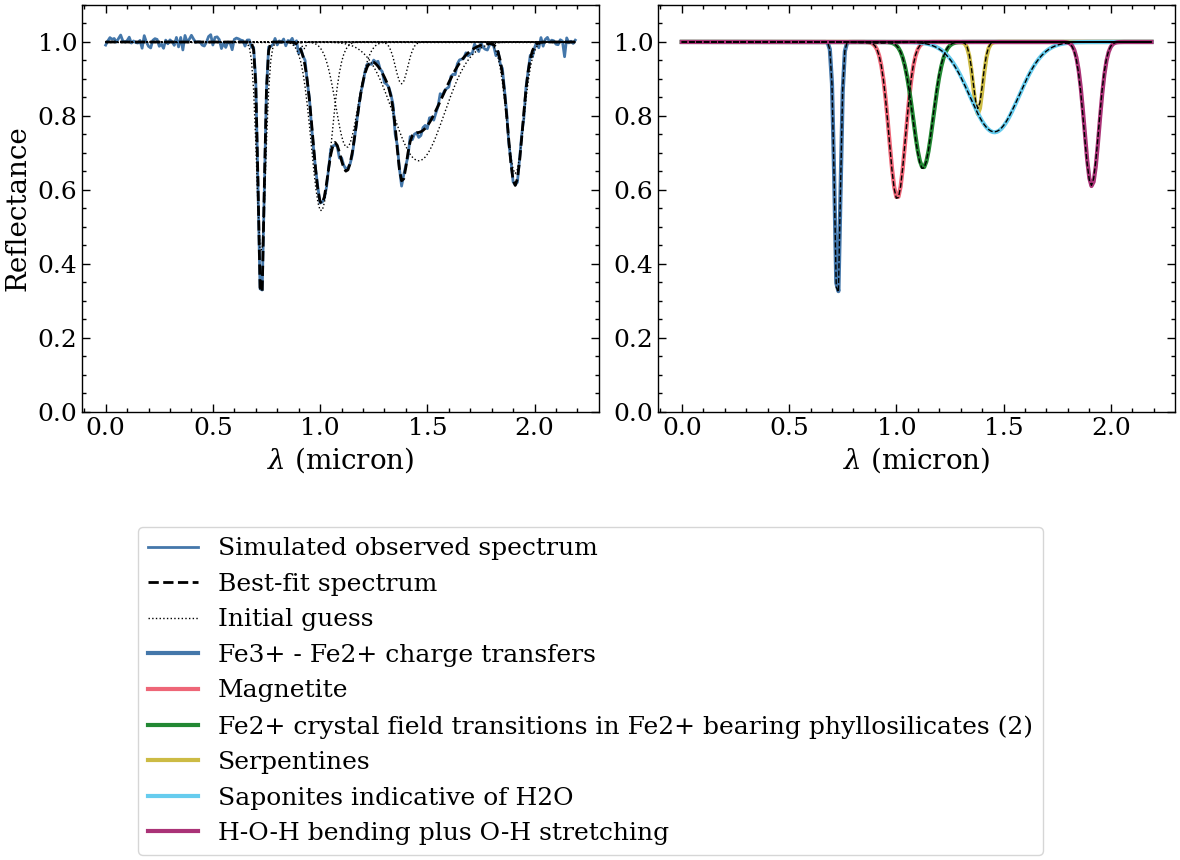

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# plot the observed spectrum
ax[0].plot(x, spectrum, '-', lw = 2, label = 'Simulated observed spectrum')

# plot the best fit spectrum
ax[0].plot(x, yt, 'k--', lw = 2, label = 'Best-fit spectrum')

# plot the best-fit components
f = []
for i,m in zip(range(9),means):
    ax[1].plot(x, -phi[i]*fast.G(x, m, sigma[i]) + eps, 'k--', zorder = 10)
    
    # and the initial guesses
    ax[0].plot(x, -initial_guess[0]['phi'][i]*fast.G(x, initial_guess[0]['mus'][i], 
                                                  initial_guess[0]['sigma'][i]) + 1, 'k:', label = ['Initial guess' if i == 0 else '__None'][0])
    

# plot the true components
for i in range(k_t):
    ax[1].plot(x, features['f'][i], lw = 3, label = linelist['label'][features['which']][i])




# format
fig.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.05))
ax[0].set_xlabel(r"$\lambda$ (micron)"); ax[1].set_xlabel(r"$\lambda$ (micron)")
ax[0].set_ylabel(r"Reflectance")
ax[0].set_ylim(0,1.1)
ax[1].set_ylim(0,1.1)
plt.show()

<a id = 'diag'></a>

### Diagnostics 

Does the model converge? Is it well-mixed? Are there a lot of divergent transitions? Is the posterior severely biased? All of these (and more!) have been problems in other models we tried. These are some of the diagnostics we used.

- [trace plots](#trace)
- [autocorrelation](#tau)
- [effective sample size](#ess)
- [corner plot](#corner)
- [energy](#energy)

[Index](#top)

<a id = 'trace'></a>

#### Trace plot

Since some of the features have $\phi = 0$, we expect their other characteristics ($\mu$, $\sigma$) to behave a little weirdly. 

[Index](#top)

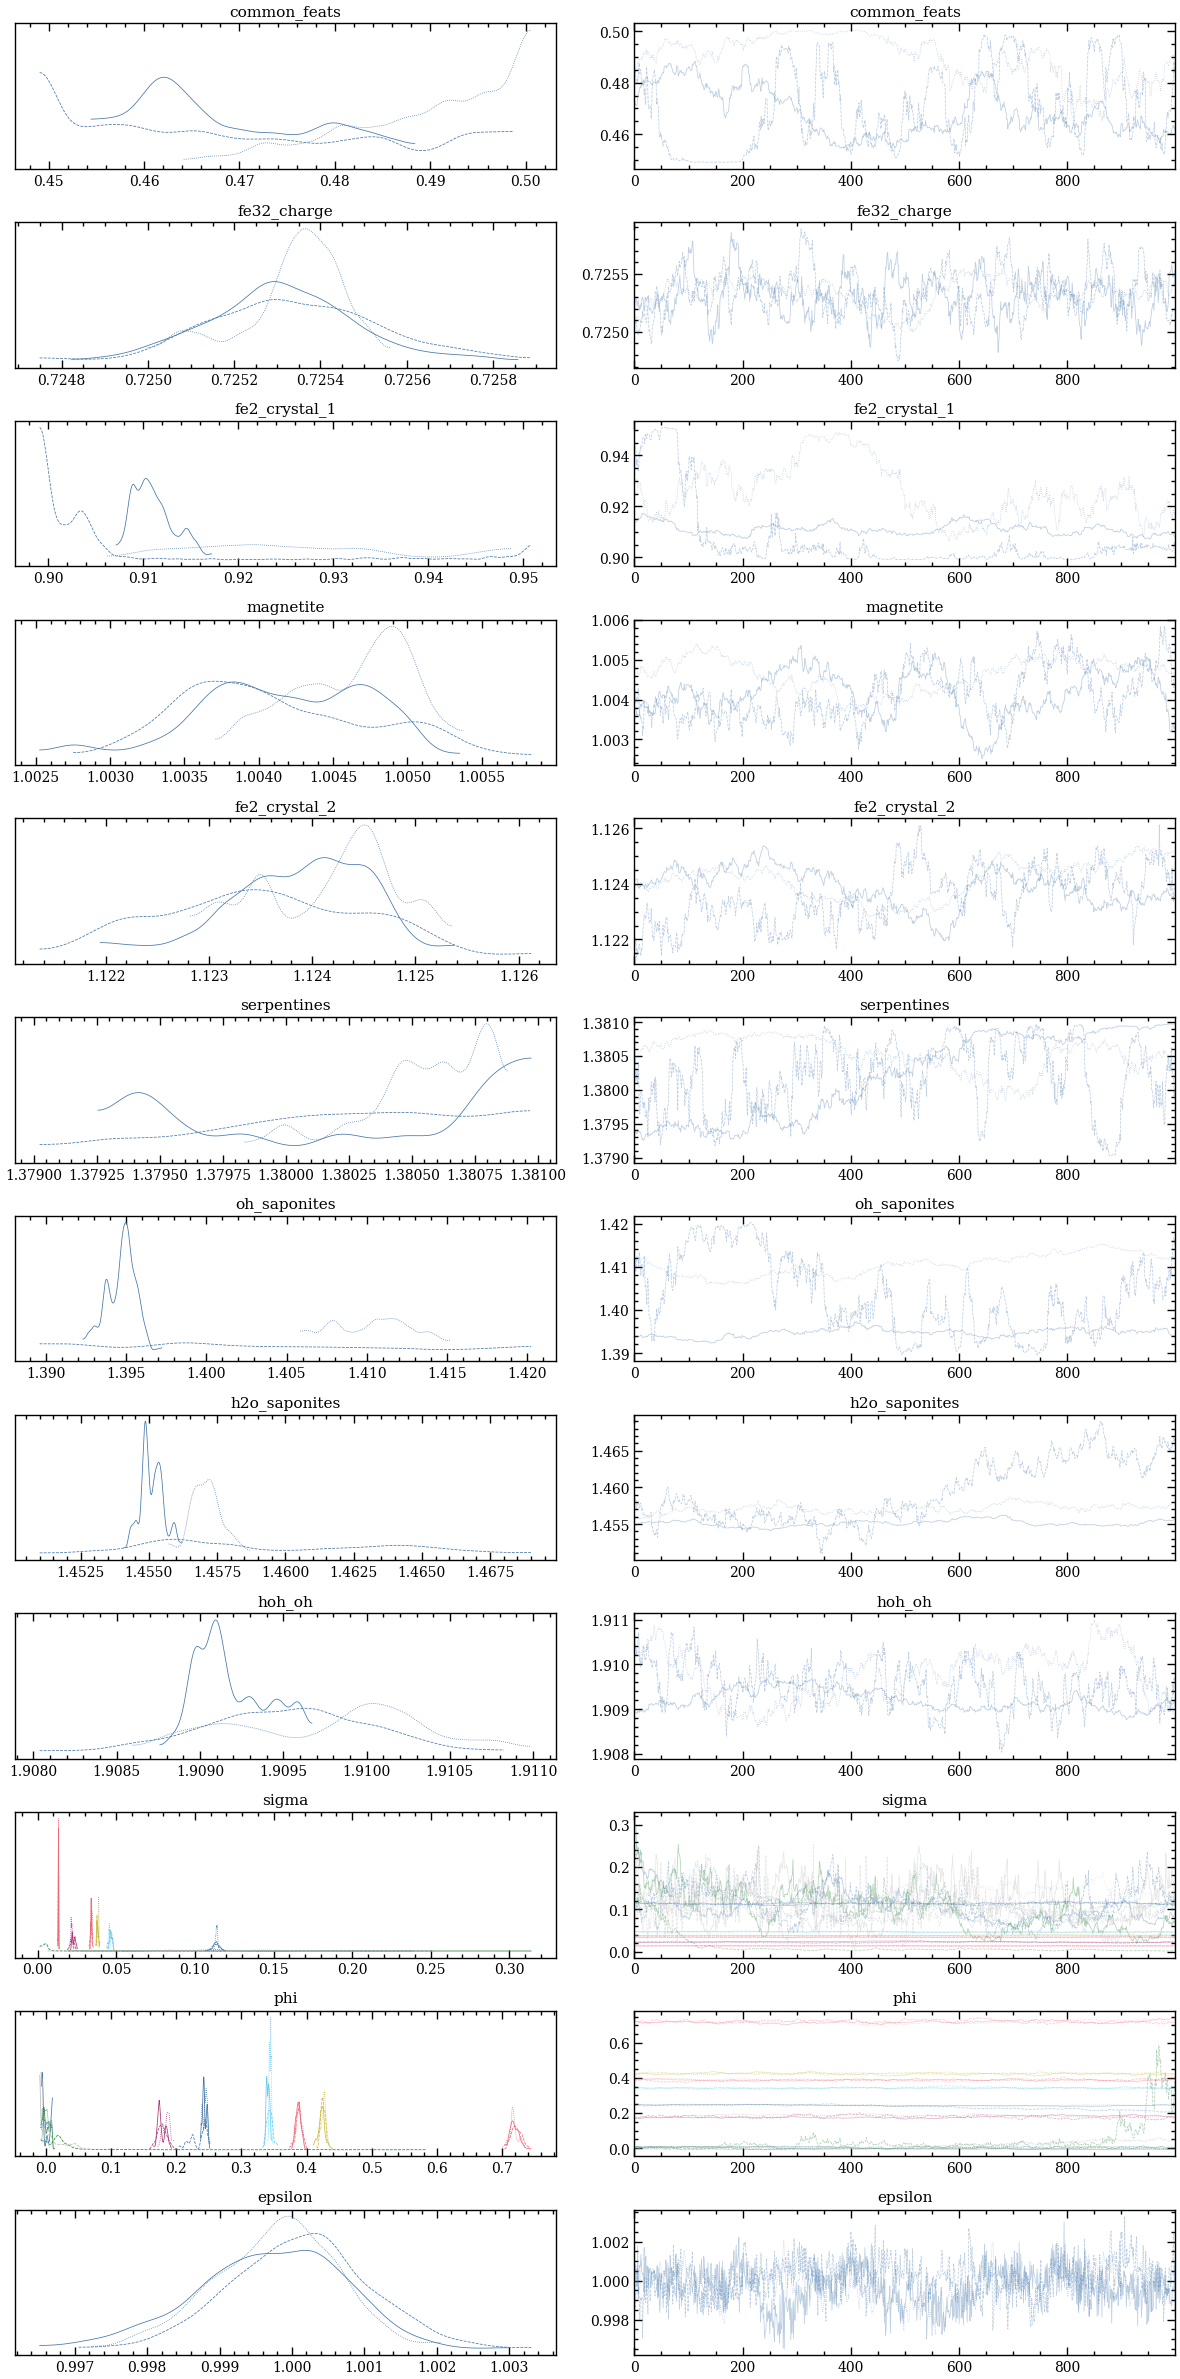

In [30]:
# means

ax = az.plot_trace(draws, var_names = ['common_feats',
                                       'fe32_charge',
                                       'fe2_crystal_1',
                                       'magnetite',
                                       'fe2_crystal_2',
                                       'serpentines',
                                       'oh_saponites',
                                       'h2o_saponites',
                                       'hoh_oh',
                                       'sigma',
                                       'phi',
                                       'epsilon'])



plt.tight_layout()

plt.show()

<a id = 'tau'></a>

#### Autocorrelation time

[Index](#top)

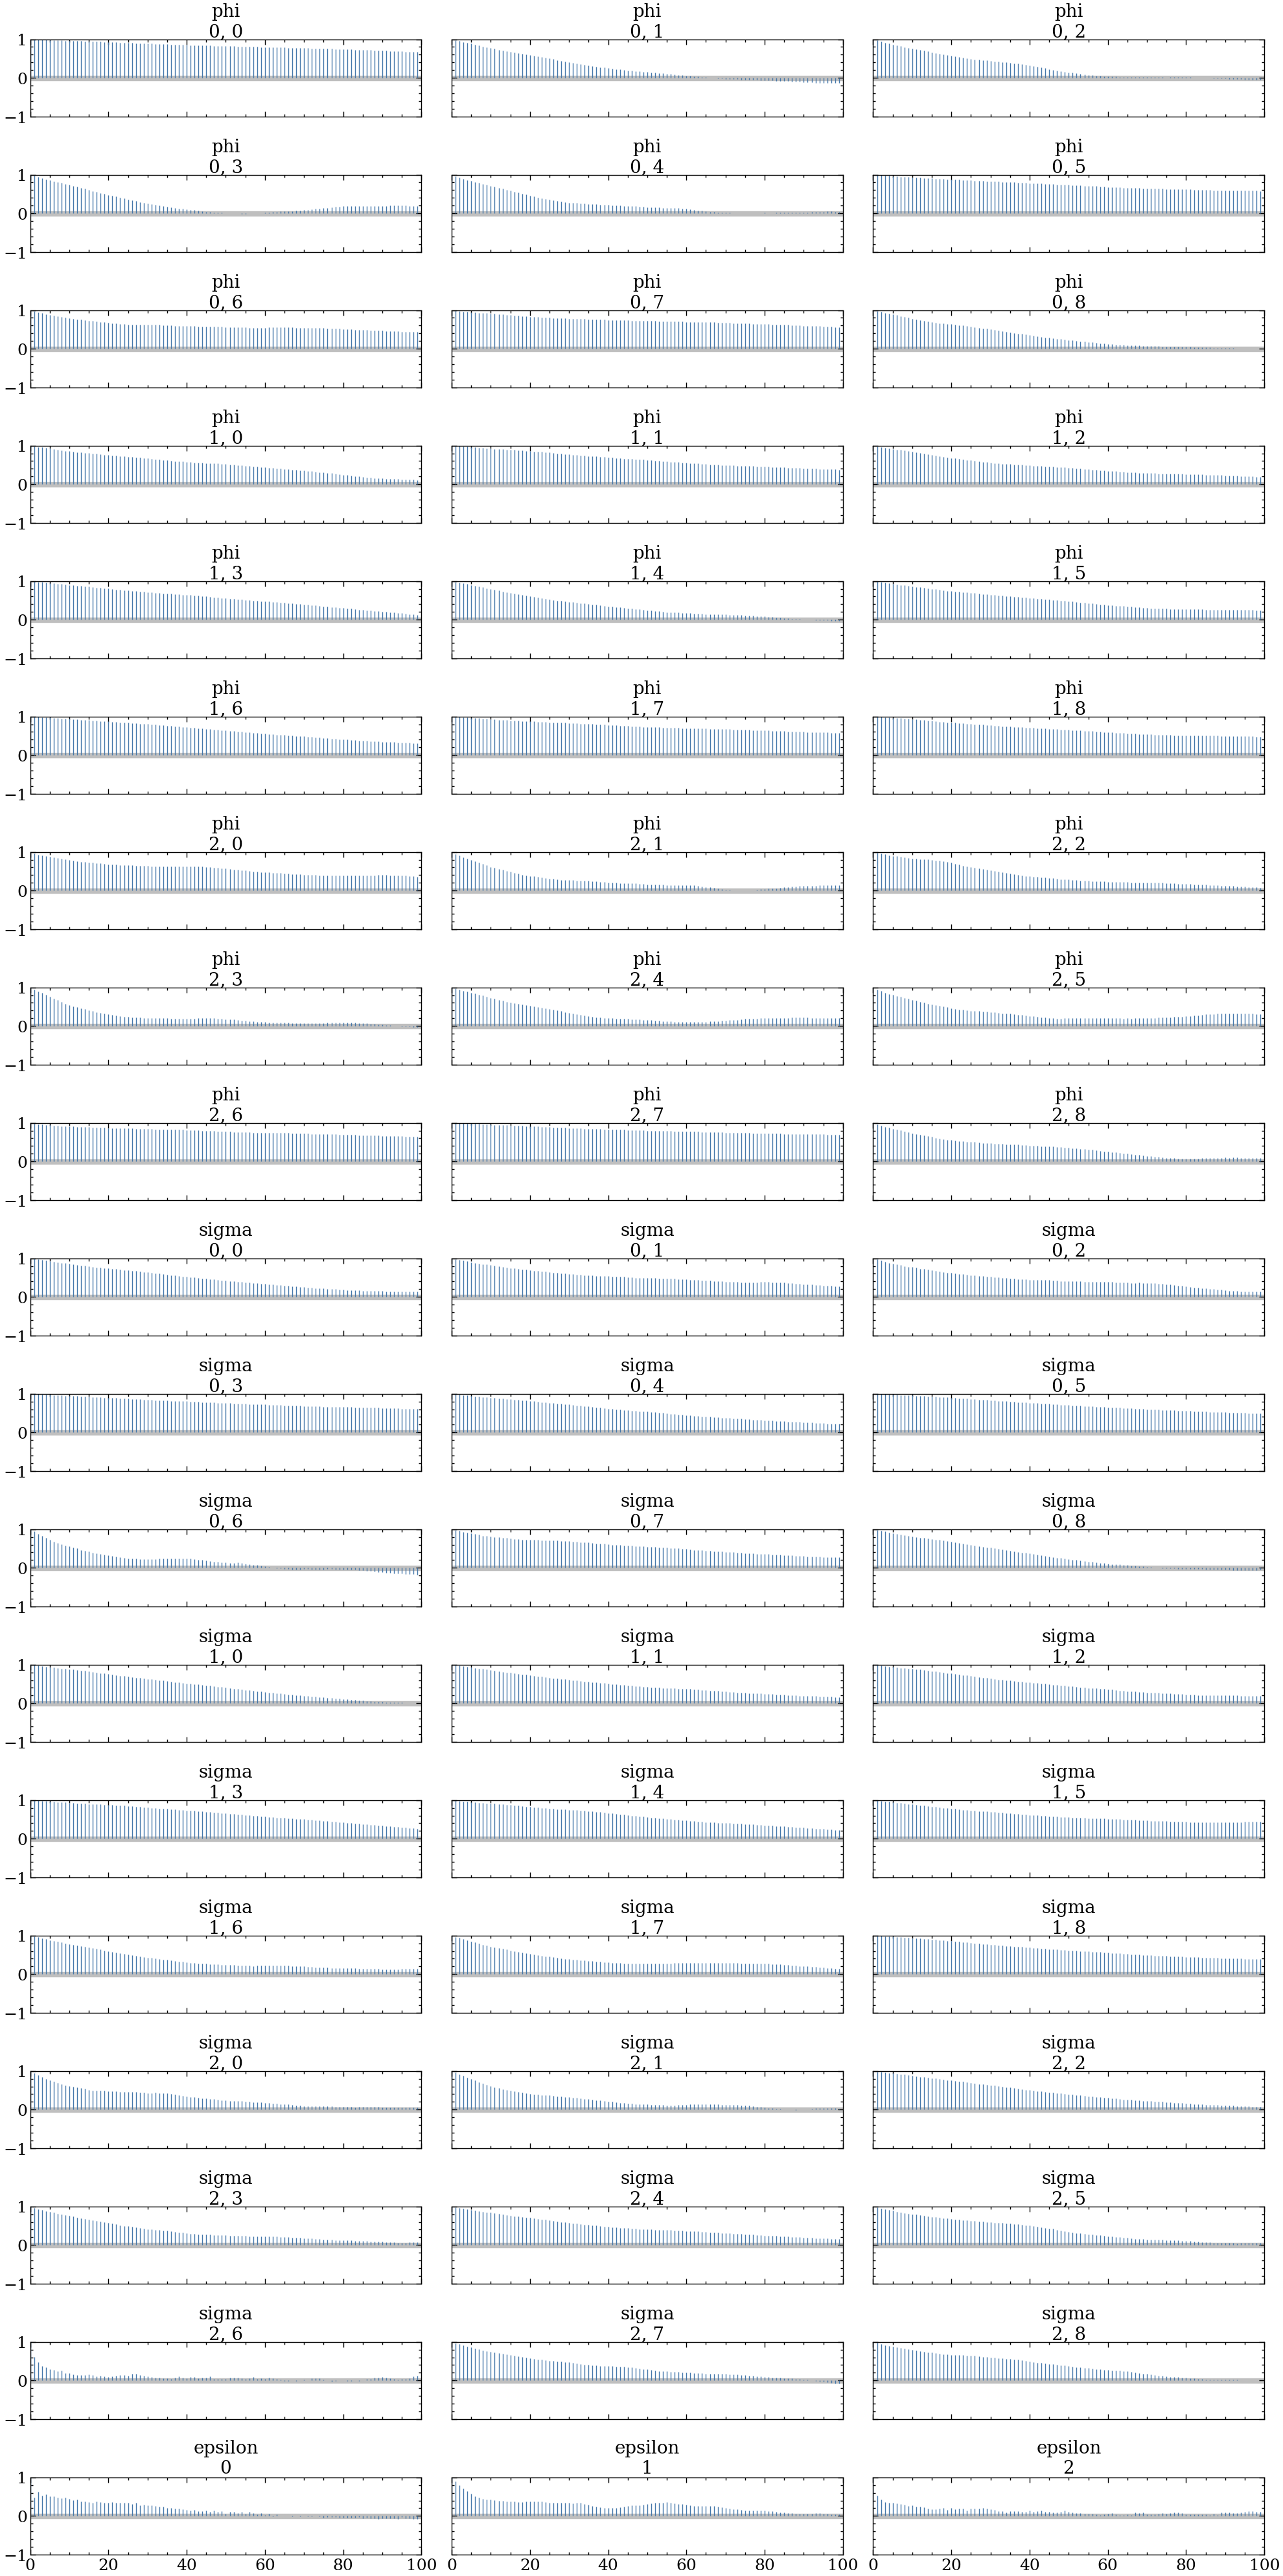

In [42]:
az.plot_autocorr(draws, var_names = ['phi', 'sigma', 'epsilon'], figsize = (20,40))

plt.tight_layout()
plt.show()

<a id = 'ess'></a>

#### Effective sample size

[Index](#top)

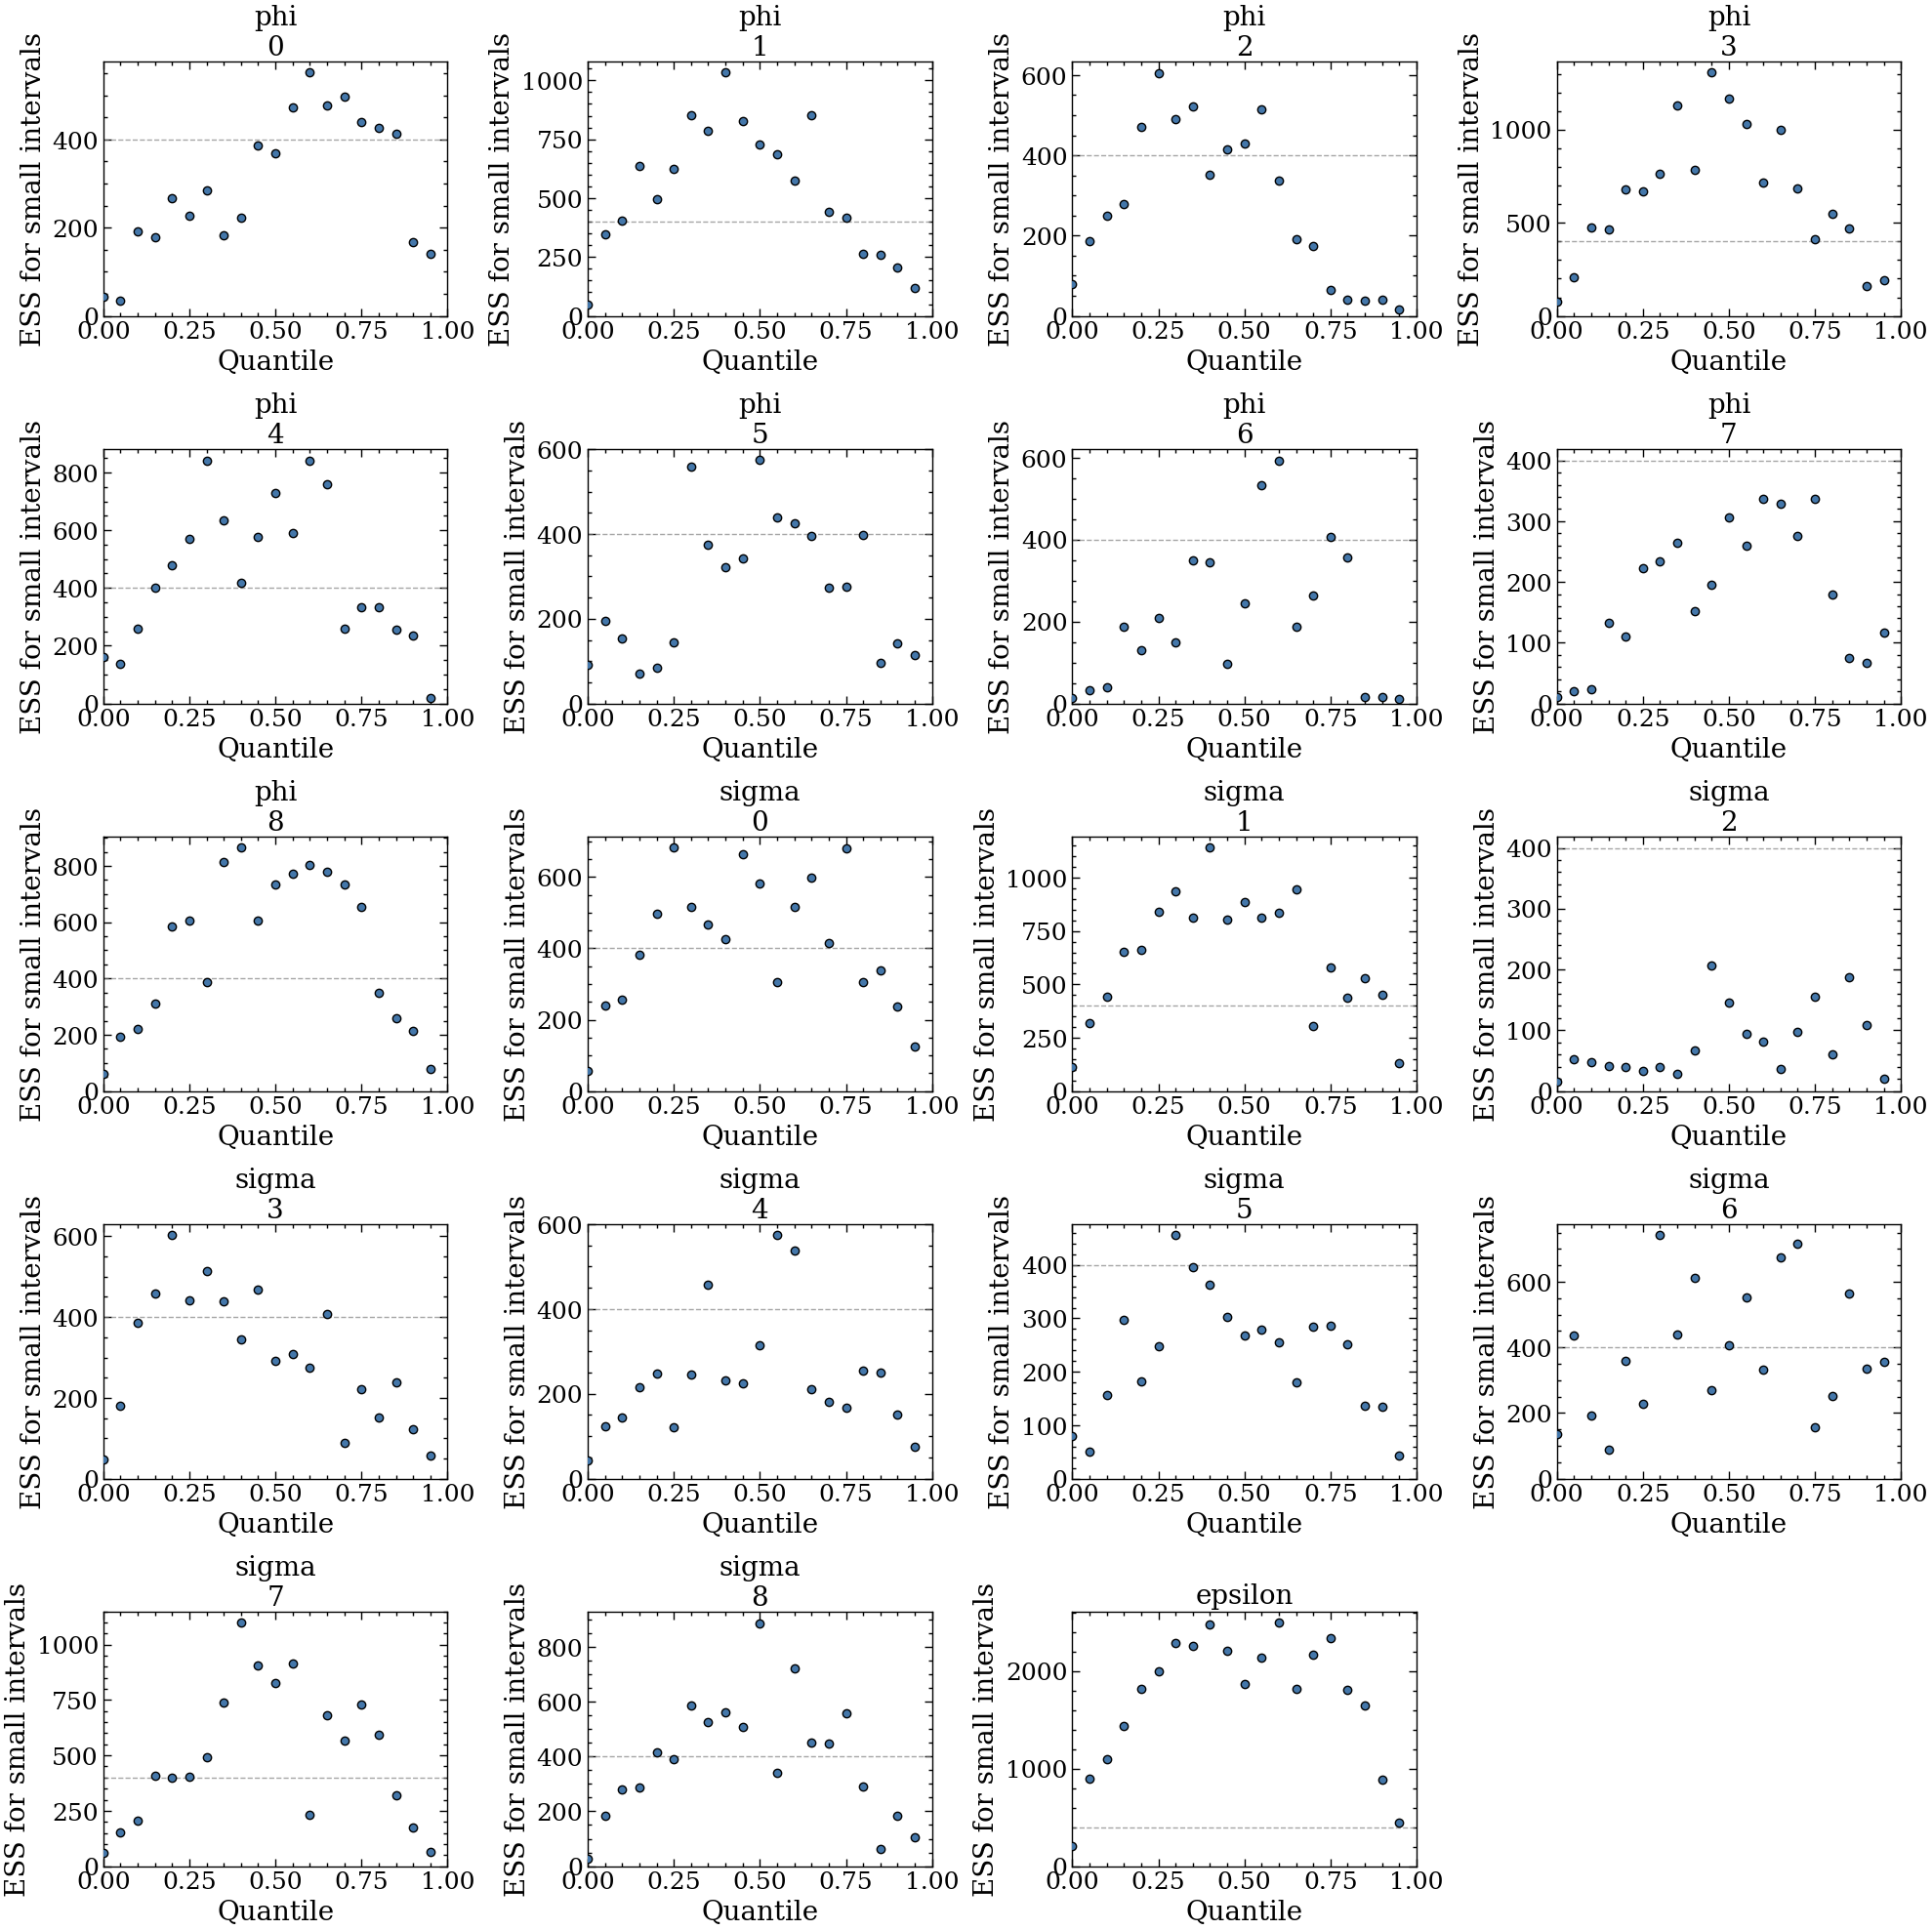

In [32]:
az.plot_ess(draws, var_names = ['phi', 'sigma', 'epsilon'], figsize = (20,20))

plt.tight_layout()
plt.show()

<a id = 'corner'></a>

#### Corner plot

[Index](#top)

In [33]:
az.rcParams["plot.max_subplots"] = 200

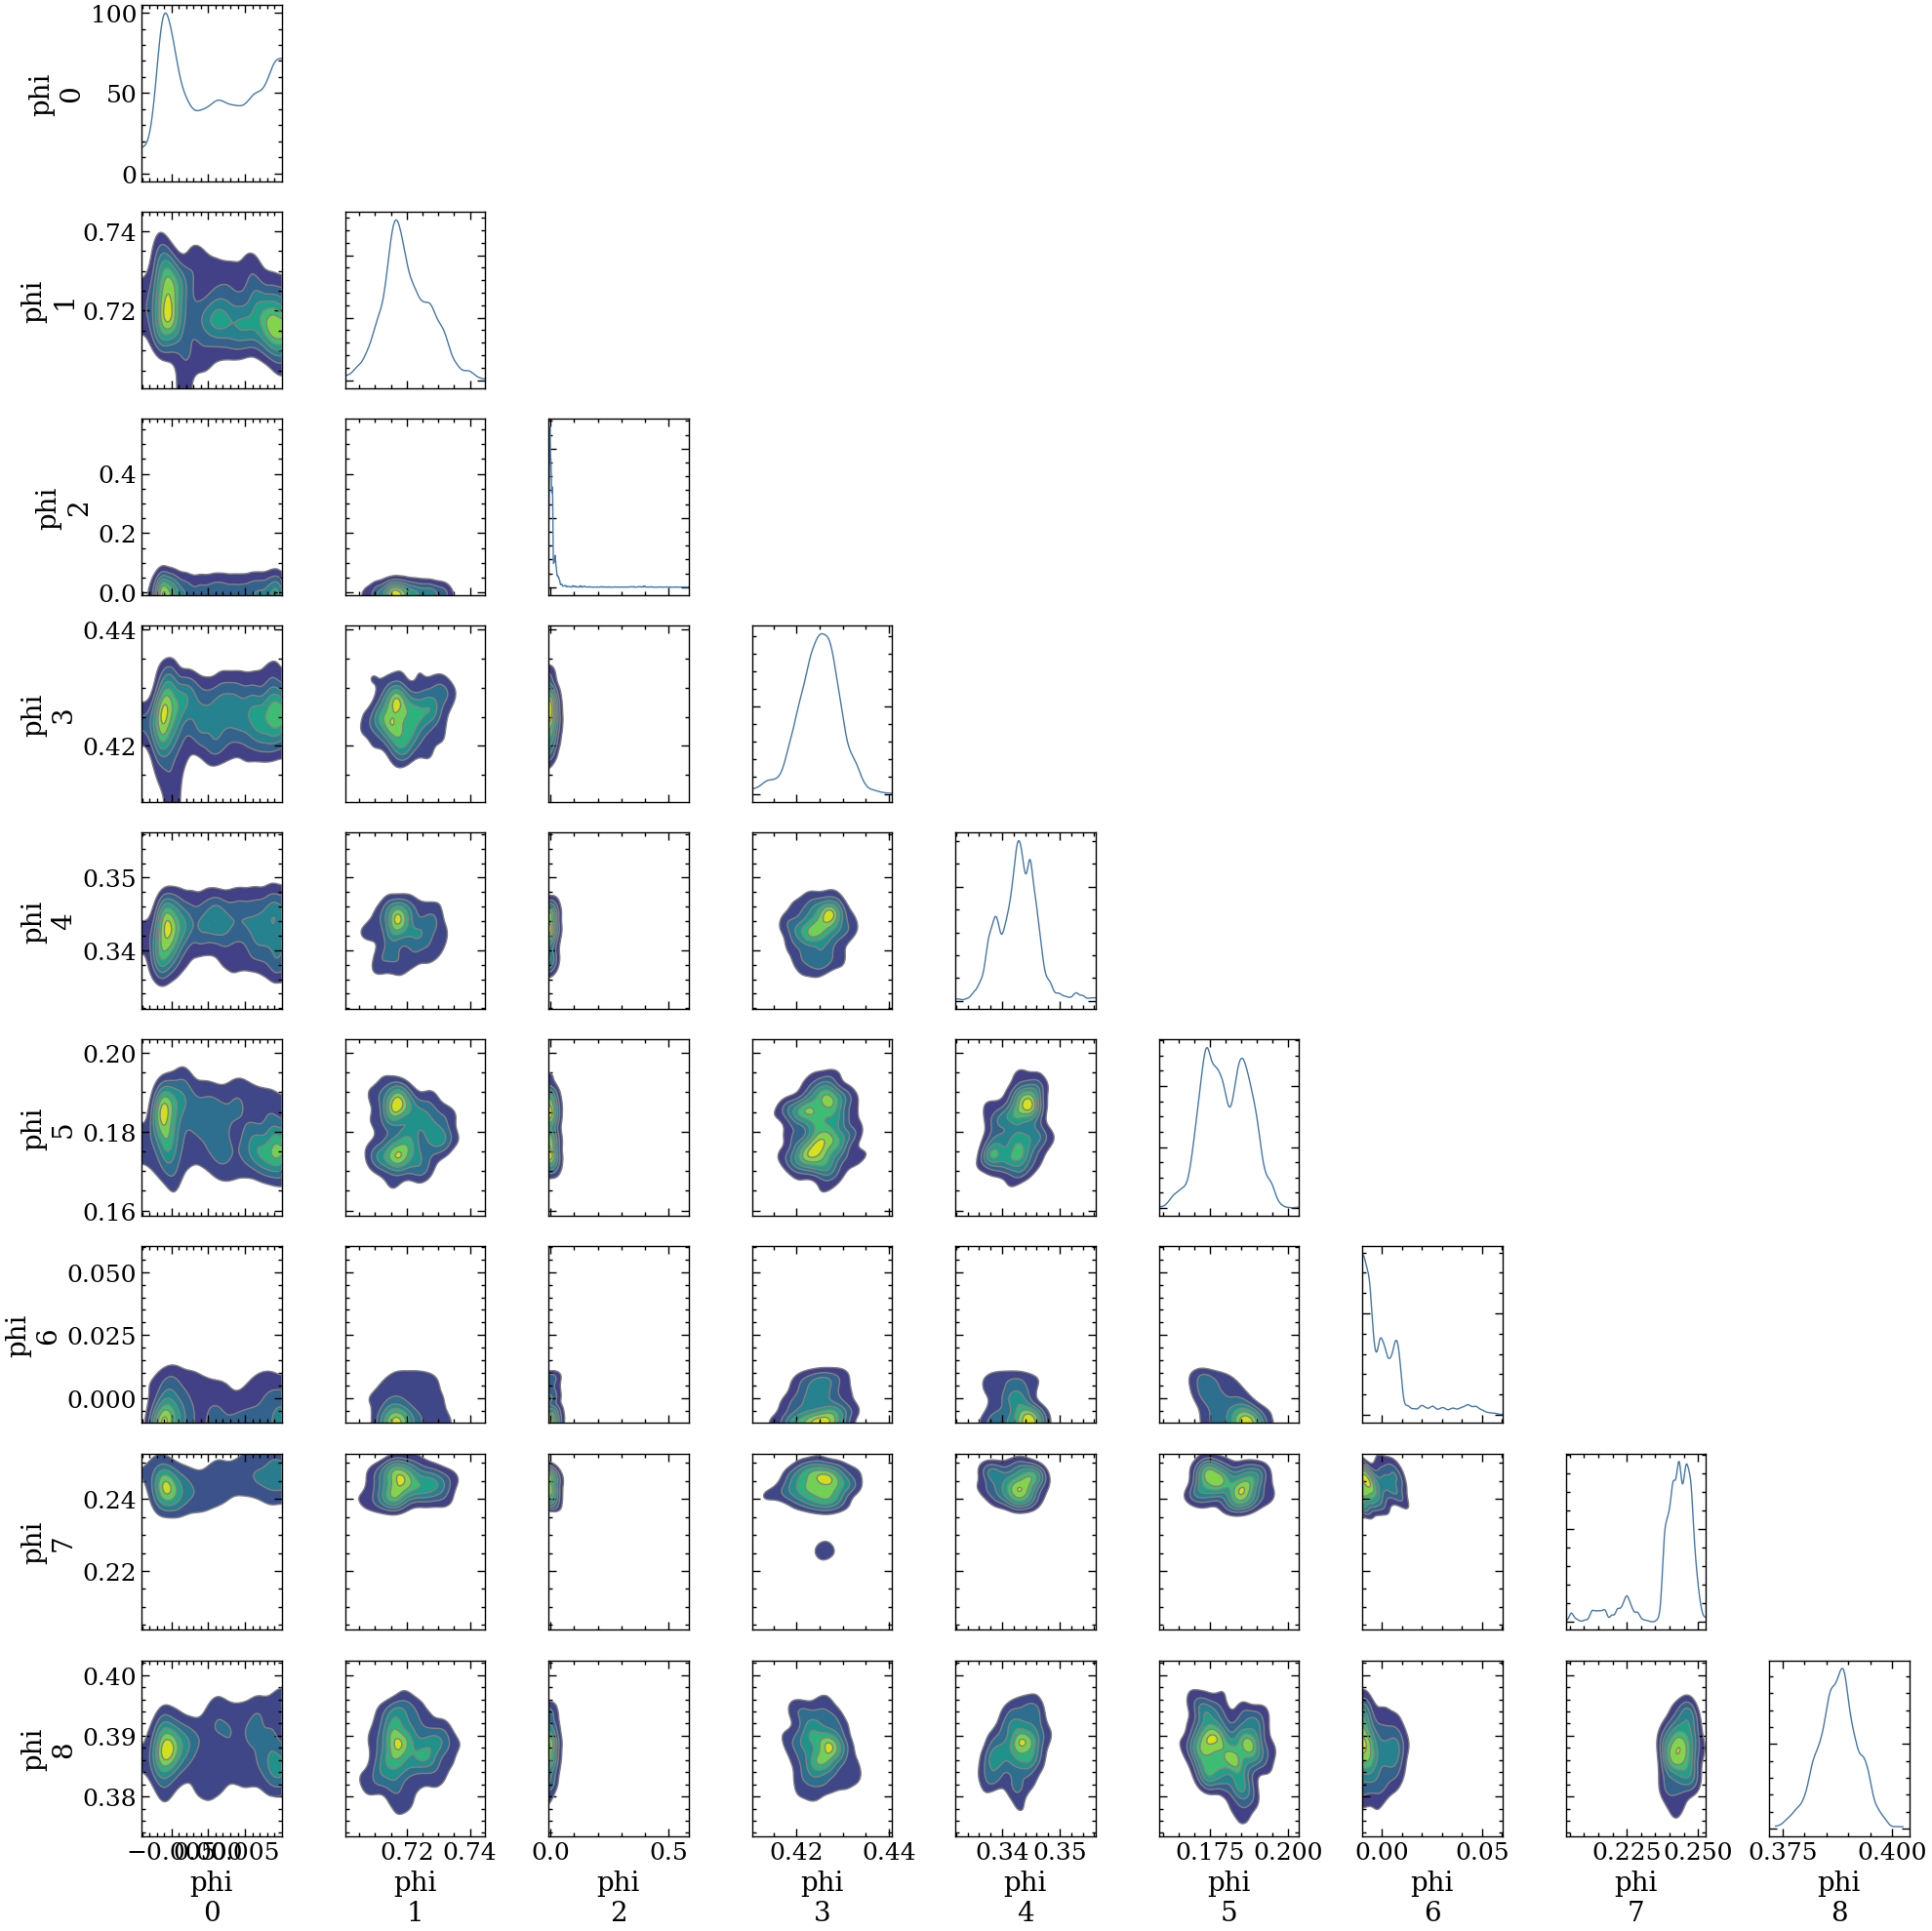

In [34]:
az.plot_pair(draws, kind = 'kde', marginals = True, var_names = ['phi'],
            figsize = (20,20))

plt.tight_layout()
plt.show()

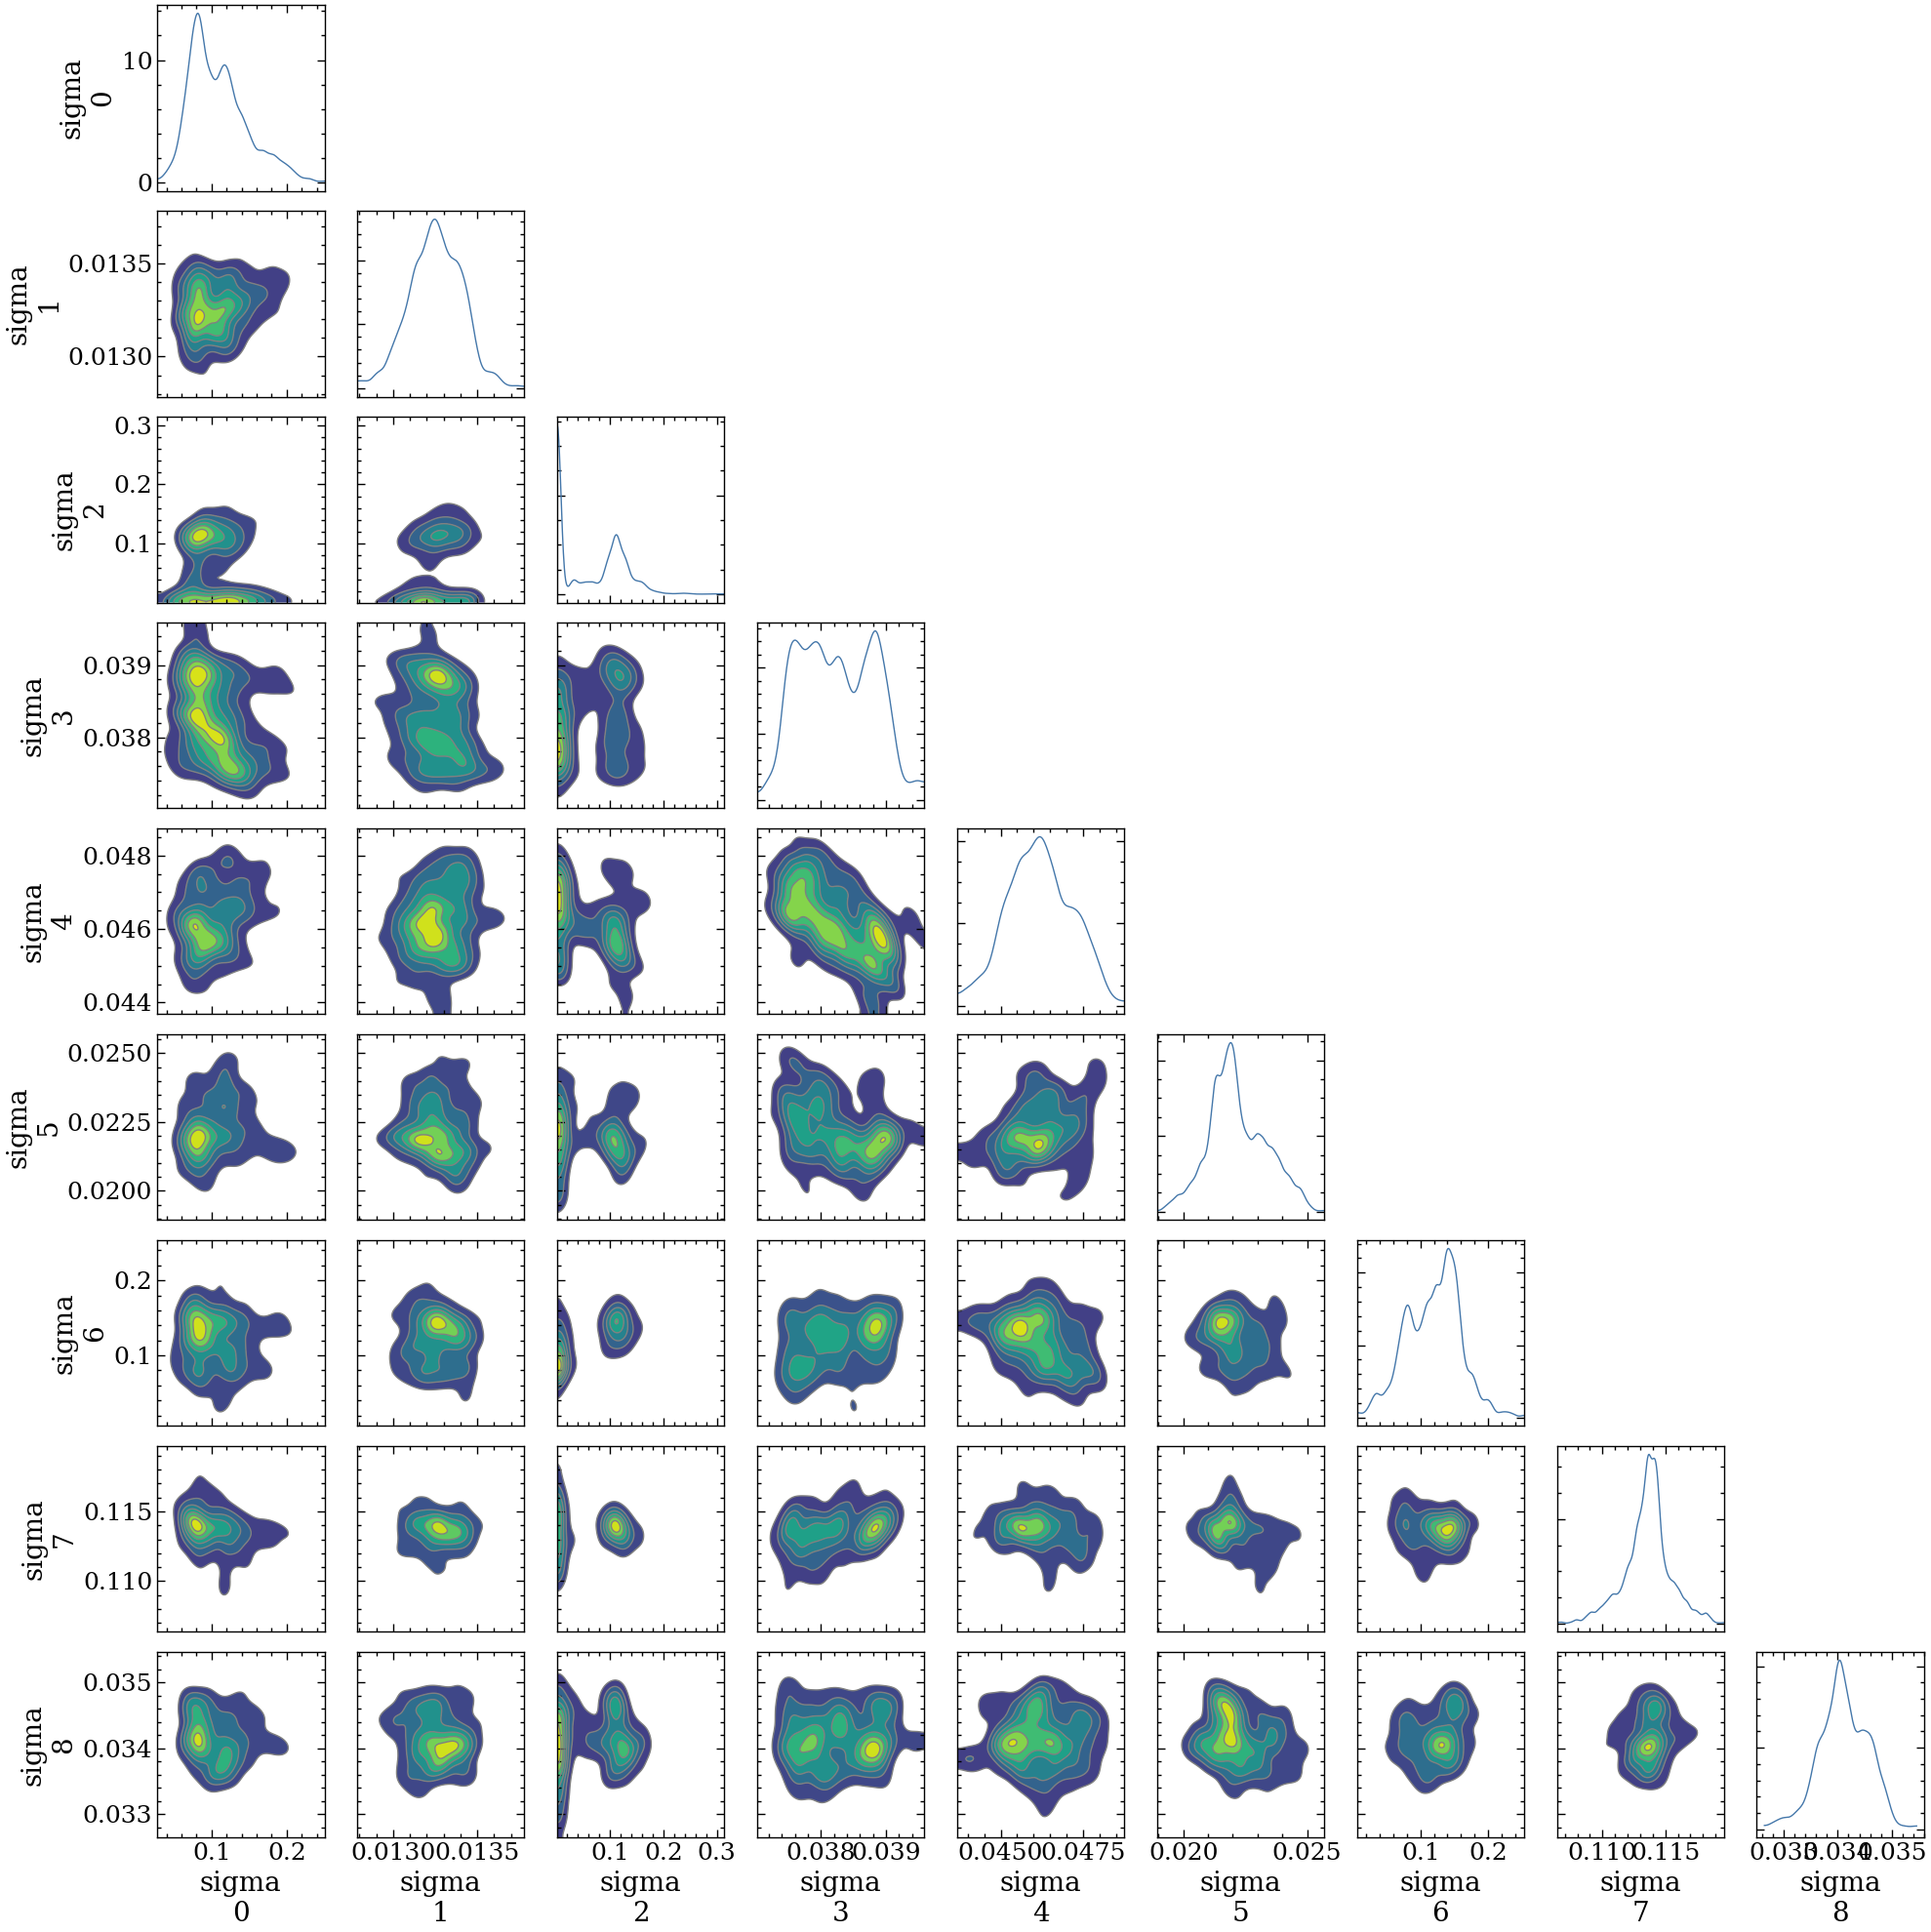

In [35]:
az.plot_pair(draws, kind = 'kde', marginals = True, var_names = ['sigma'],
            figsize = (20,20))

plt.tight_layout()
plt.show()

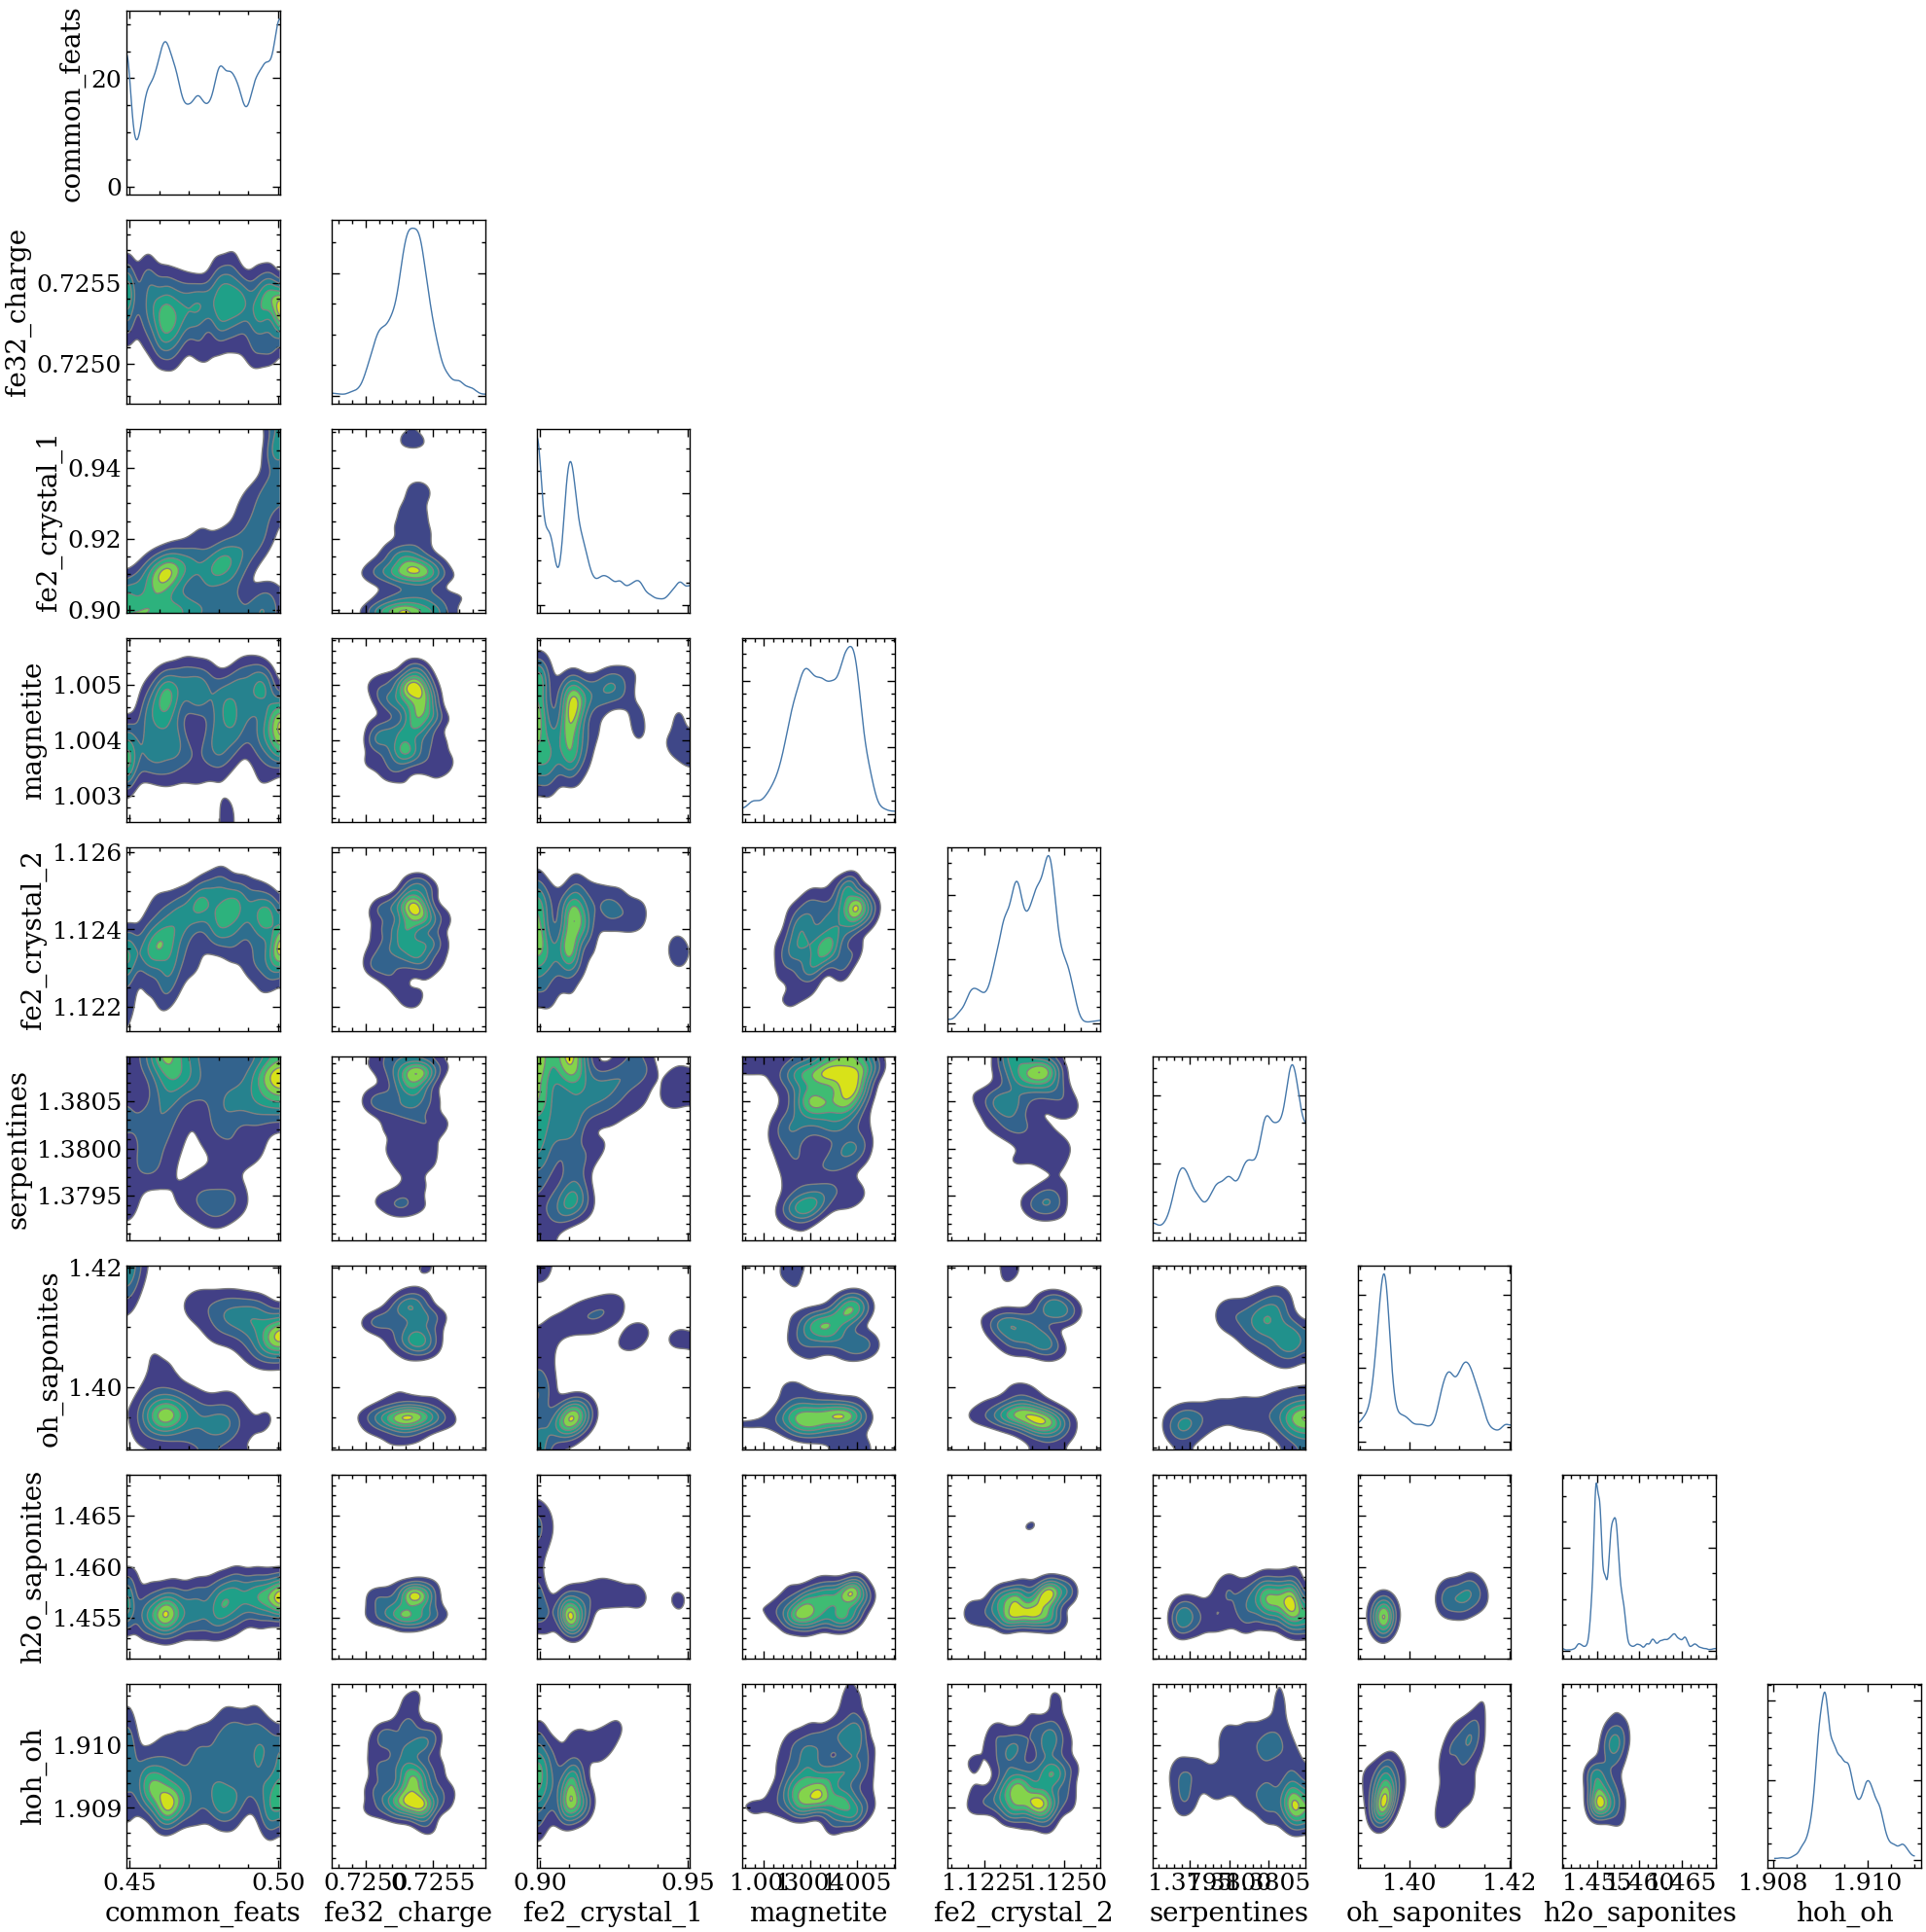

In [36]:
az.plot_pair(draws, kind = 'kde', marginals = True, var_names = ['common_feats',
                                       'fe32_charge',
                                       'fe2_crystal_1',
                                       'magnetite',
                                       'fe2_crystal_2',
                                       'serpentines',
                                       'oh_saponites',
                                       'h2o_saponites',
                                       'hoh_oh'],
            figsize = (20,20))

plt.tight_layout()
plt.show()

<a id = 'energy'></a>

#### Energy plot


[Index](#top)

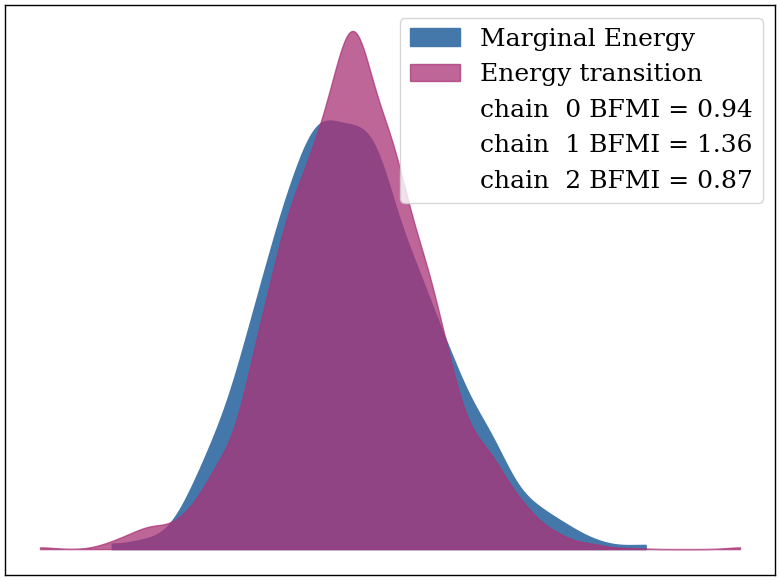

In [37]:
az.plot_energy(draws)

plt.show()

<a id = 'goodness'></a>

### Goodness of fit

- [Model](#stan)
- [Diagnostics](#diag)

[Index](#top)

/home/heigerma/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


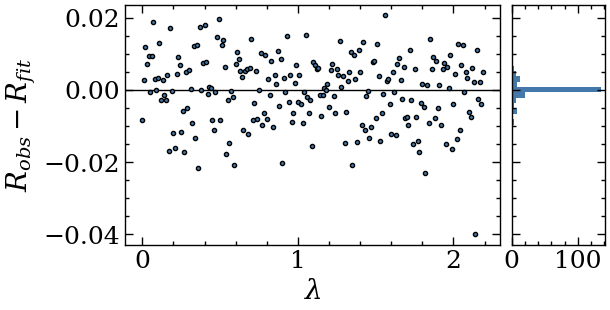

In [38]:
# residuals
# there's no discernable pattern in lambda to the residuals 
# and they're roughly Gaussian, which is good (esp since the error is Gaussian and we're comparing observed/fit and not true/fit)
# the difference is on the order of 10%, which is the order of the error

fig = plt.figure(figsize = (6, 3))
gs = fig.add_gridspec(1, 2,  width_ratios=(4, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[0])
ax_histy = fig.add_subplot(gs[1], sharey=ax)

ax.axhline(0, color = 'k')
ax.plot(x, data['yo'] - yt, '.')

ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.hist(np.sum(features['f'], axis = 0) - 5 - yt, orientation = 'horizontal', bins = 20)

ax.set_xlabel("$\lambda$")
ax.set_ylabel("$R_{obs} - R_{fit}$")

plt.show()

In [39]:
##### r2 score
az.r2_score(data['yo'], yt)

r2        0.995293
r2_std    0.000000
dtype: float64